In [1]:
%matplotlib inline
import pylab
import seaborn
import numpy as np
import nengo

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class RegularSpiking(object):
    def __init__(self, size, dt=0.001):
        self.state = np.zeros(size)
        self.threshold = 1.0 / dt
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        self.state += x
        spikes = np.where(self.state > self.threshold)
        self.output[spikes] = self.threshold
        self.state -= self.output
        return self.output

Here, we just check if there are any events within dt time, and if there are, we assume there is only one of them.

This is a horrible approximation.  Don't do this.

In [3]:
class PoissonSpikingApproximate(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        p = 1.0 - np.exp(-x*self.dt)
        self.output[p>self.rng.rand(self.size)] = self.value
        return self.output

For this attempt, I'm screwing something up in the logic, as it's firing more frequently than it should.  The idea is to use the same approach as above to see if *any* spikes happen during the dt.  If there are any spikes, then count that as 1 spike.  But now I need to know if there are any more spikes (given that we know at least one spike happened).  Since one spike happened at one instant in time, but all the other points in time during that dt could also have a spike (since the whole point of a poisson process is that everything's independent), we can remove that one infinitessimal point in take from dt, leaving us with dt, and we can check if any spikes happened in that remaining time.  In other words, just do the same process over again, only considering those neurons who did spike on the previous iteration of this logic.  Continue until no neurons have another spike.

I'm not sure if my logic is bad or my coding is bad, but this doesn't work.

In [84]:
class PoissonSpikingExactBad(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def __call__(self, t, x):
        p = 1.0 - np.exp(-x*self.dt)
        self.output[:] = 0
        s = np.where(p>self.rng.rand(self.size))[0]
        self.output[s] += self.value
        count = len(s)
        while count > 0:
            s2 = np.where(p[s]>self.rng.rand(count))[0]
            s = s[s2]
            self.output[s] += self.value
            count = len(s)
            
        return self.output

Now for one that works.  Here we do the approach of actually figuring out when during the time step the events happen, and continue until we fall off the end of the timestep.  This is how everyone says to do it.

In [85]:
class PoissonSpikingExact(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def next_spike_times(self, rate):        
        return -np.log(1.0-self.rng.rand(len(rate))) / rate
    def __call__(self, t, x):
        self.output[:] = 0
        
        next_spikes = self.next_spike_times(x)
        s = np.where(next_spikes<self.dt)[0]
        count = len(s)
        self.output[s] += self.value
        while count > 0:
            next_spikes[s] += self.next_spike_times(x[s])
            s2 = np.where(next_spikes[s]<self.dt)[0]
            count = len(s2)
            s = s[s2]
            self.output[s] += self.value
                
        return self.output

In [86]:
model = nengo.Network()
with model:
    freq=10
    stim = nengo.Node(lambda t: np.sin(t*np.pi*2*freq))
    ens = nengo.Ensemble(n_neurons=5, dimensions=1, neuron_type=nengo.LIFRate(), seed=1)
    nengo.Connection(stim, ens, synapse=None)
    
    regular_spikes = nengo.Node(RegularSpiking(ens.n_neurons), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, regular_spikes, synapse=None)

    poisson_spikes = nengo.Node(PoissonSpikingExact(ens.n_neurons, seed=1), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, poisson_spikes, synapse=None)
    
    p_rate = nengo.Probe(ens.neurons)
    p_regular = nengo.Probe(regular_spikes)
    p_poisson = nengo.Probe(poisson_spikes)
sim = nengo.Simulator(model)
sim.run(0.1)

Simulation finished in 0:00:01.                                                 


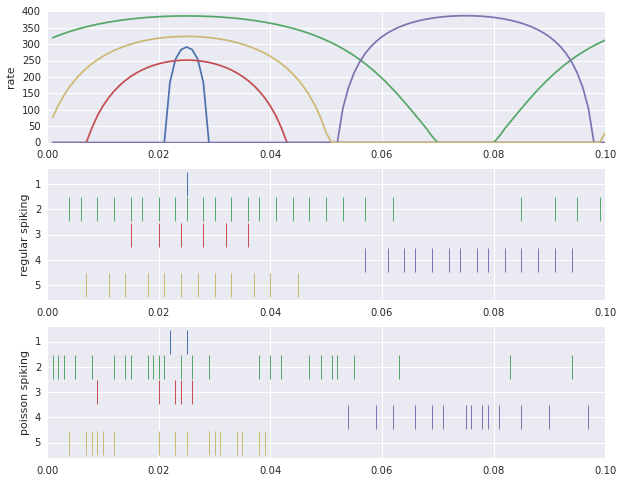

In [87]:
pylab.figure(figsize=(10,8))

pylab.subplot(3,1,1)
pylab.plot(sim.trange(), sim.data[p_rate])
pylab.xlim(0, sim.time)
pylab.ylabel('rate')

pylab.subplot(3,1,2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_regular])
pylab.xlim(0, sim.time)
pylab.ylabel('regular spiking')

pylab.subplot(3,1,3)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_poisson])
pylab.xlim(0, sim.time)
pylab.ylabel('poisson spiking')



pylab.show()

Let's test the accuracy of these models.

In [88]:
def test_accuracy(cls, rate, T=1):
    test_model = nengo.Network()
    with test_model:
        stim = nengo.Node(rate)
        spikes = nengo.Node(cls(1, seed=1), size_in=1)
        nengo.Connection(stim, spikes, synapse=None)

        p = nengo.Probe(spikes)
    sim = nengo.Simulator(test_model)
    sim.run(T, progress_bar=False)
    return np.mean(sim.data[p])

In [89]:
rates = np.linspace(0, 1000, 11)
result_approx = [test_accuracy(PoissonSpikingApproximate, r) for r in rates]
result_bad = [test_accuracy(PoissonSpikingExactBad, r) for r in rates]
result_exact = [test_accuracy(PoissonSpikingExact, r) for r in rates]

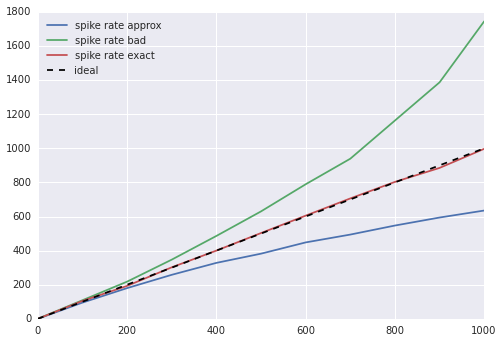

In [91]:
pylab.plot(rates, result_approx, label='spike rate approx')
pylab.plot(rates, result_bad, label='spike rate bad')
pylab.plot(rates, result_exact, label='spike rate exact')
pylab.plot(rates, rates, ls='--', c='k', label='ideal')
pylab.legend(loc='best')
pylab.show()